In [59]:
# !pip install watchdog

import numpy as np
import scipy.misc as misc
import pandas as pd
import re,scipy,os,json,time
import logging
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
import scipy.io
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
from sklearn.externals import joblib
import shutil
import imp 
util = imp.load_source('f_plot_obj', 'fotranPlot/fPlotFuntion.py') 
import f_plot_obj
print(scipy.__version__)
import time
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s : %(message)s', filename='inference.log')
console = logging.StreamHandler()
console.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(levelname)s : %(message)s')
console.setFormatter(formatter)
logging.getLogger('').addHandler(console)

global NE
global TRAINING_SET 
global PAGE
global DATASET_PATH
global RESULT_PATH
global MODEL_NAME



1.1.0


In [60]:
# n_estimators
# NE = 50
# NE = sys.argv[2]

# traning model 
# TRAINING_SET = 5000
# TRAINING_SET = sys.argv[1]

# DEFAULT
PAGE = 20

DATASET_PATH = '/home/cuda/benchuang/TONG_well_inverse_new/'
DIR_PATH_COV = '/home/cuda/benchuang/TONG_random_forest/'
# RESULT_PATH = '/home/cuda/ResultDirectory'
RESULT_PATH = '/home/cuda/benchuang/TONG_random_forest/ResultDirectory'


# rf_(traingsize)_(page)_(n_estimators)
# MODEL_NAME = 'rf_{0}_{1}_{2}'.format(TRAINING_SET, PAGE, NE)
MODEL_PATH = '/home/cuda/benchuang/TONG_random_forest/rf_model_covariance_4000'
MODEL_NAME = 'rf_model_covariance_4000'

In [61]:
def prepare_dataset(args_list):
    
    dir_path = arg_list['dir_path']
    DIR_PATH_COV = arg_list['DIR_PATH_COV']
    seqs = arg_list['seqs']
    _num = arg_list['_num']
    _lags = arg_list['_lags']

    # filename, example F0000001, F0000002
#     seqs = ['F'+str(i).zfill(7) for i in seqs]
    seqs = ['F'+str(seqs).zfill(7)]

    # Stress01.JSON, Stress02.JSON
    num = range(1,_num+1)
    num = ['Stress'+str(i).zfill(2)+'.JSON' for i in num]

    # preprocess start time
    start = time.time()

    dataframe = []
    for s_index, seq in enumerate(seqs):
                print(seq)
                with open(os.path.join(dir_path, seq, 'material.JSON')) as f:
                    data = json.loads(f.read())['20*20']
                data = np.array(data).reshape([20,20]) 

                # label image
                label= []
                for r_index, row in enumerate(data):
                    for e_index, e in enumerate(row):
                    # Label image introduction
                    # e: value. (float)
                    # r_index: y axis index. (1-21)
                    # e_index: x axis index. (1-21)
                    # s_index: page number (1-20)
                        label.append([e, r_index, e_index, s_index])        

                stress=[]
                for n_index, n in enumerate(num):
                    for lag in range(_lags):
                        # 'Stress01.JSON_lag0', 'Stress01.JSON_lag1'
                        filepath = os.path.join(DIR_PATH_COV, seq, '{0}_lag{1}'.format(n, lag))
                        with open(filepath, 'r') as f:
                            data = json.loads(f.read())
                        # Label image introduction
                        # e: value. (float)
                        # r_index: y axis index. (1-21)
                        # e_index: x axis index. (1-21)
                        # s_index: page number (1-20)
                        for r_index, row in enumerate(data):
                            for e_index, e in enumerate(row):
                                stress.append([e, r_index, e_index, lag, n_index, s_index])

                for y in range(20):
                    for x in range(20):
                        feature=[]
                        feature.append(y)
                        feature.append(x)
                        for sp in stress:
                            if sp[1]==x and sp[2]==y:
                                feature.append(sp[0])
                            if sp[1]==x and sp[2]==y+1:
                                feature.append(sp[0])                            
                            if sp[1]==x+1 and sp[2]==y:
                                feature.append(sp[0])
                            if sp[1]==x+1 and sp[2]==y+1:
                                feature.append(sp[0])
                        for row in label:
                            if row[1]==y and row[2]==x:
                                feature.append(row[0])                 
                        dataframe.append(feature)
    dataframe = pd.DataFrame(dataframe)
    logging.info(np.shape(dataframe))

    # preprocess end time
    end = time.time()
    loading_elapsed = end - start

    logging.info('loading elapsed time: {0} seconds'.format(loading_elapsed))

    return dataframe[dataframe.columns[0:2402]], dataframe[dataframe.columns[2402]]

# seqs=9001
# arg_list=dict(dir_path=DATASET_PATH,
#               DIR_PATH_COV=DIR_PATH_COV,
#               seqs=seqs,
#               _num=20,
#               _lags=30
#              )
# validation_path = os.path.join(DATASET_PATH, 'FOOO9001')
# f,l = prepare_dataset(arg_list)

In [4]:
def plot_stress(seqs):
        print(seqs)
#         validation_name = [e for e in validation_path.split(os.path.sep) if e is not ''][-1]
        validation_name = ['F'+str(seqs).zfill(7)][0]
        logging.info('Plot stress: {}'.format(validation_name))
        format = 0
        
        if not os.path.exists(os.path.join(RESULT_PATH, validation_name)  ):
            os.mkdir(os.path.join(RESULT_PATH, validation_name) )
            
        stress_names = ['Stress'+str(i).zfill(2)+'.JSON' for i in range(1,PAGE+1)]
        for n_index, stress_name in enumerate(stress_names):
            filepath = os.path.join(DATASET_PATH, validation_name, stress_name)        
            with open(filepath) as f:
                data = json.loads(f.read())['21*21']
                
            f_plot_obj.f_plot_obj.f90_plot(file_num=30, pixel_list=data, format=format, x=21, y=21)
            file = [item for item in os.listdir() if 'RES' in item][0]
            os.rename(file, stress_name.replace('.JSON','.dat'))
            shutil.move(stress_name.replace('.JSON','.dat'), 
                        os.path.join(RESULT_PATH, validation_name, stress_name.replace('.JSON','.dat')))
            
            logging.debug(stress_name)


In [62]:
def inference(arg_list):
#     num = range(1, PAGE)
#     num = ['Stress'+str(i).zfill(2)+'.JSON' for i in num]
    seqs = arg_list['seqs']
    validation_name = ['F'+str(seqs).zfill(7)]  
        
    # Predict start time
    start = time.time()

    val_X, val_y = prepare_dataset(arg_list)
    rf = joblib.load(MODEL_PATH)
    predicted_dataset = rf.predict(val_X)

    # Predict end time
    end = time.time()
    elapsed = end - start
    logging.info('Predict {} spends {} seconds'.format(arg_list['seqs'], round(elapsed, 2)))

    
    # Calculate the absolute errors
    errors = abs(predicted_dataset - val_y)

    # Print out the mean absolute error (mae)
#     print('Mean_Absolute_Error:', round(np.mean(errors), 2), 'degrees.')

    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / val_y)

    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
#     print('Accuracy:', round(accuracy, 2), '%.')

    # Reshape array to 2-d
    image = np.array(predicted_dataset).reshape([20,20])
    val_image = np.array(val_y).reshape([20,20])
    
    creteria = dict(
        test_score = r2_score(val_y, predicted_dataset),
        spearman = list(spearmanr(val_y, predicted_dataset)),
        pearson = list(pearsonr(val_y, predicted_dataset)),
        Mean_Absolute_Error = round(np.mean(errors), 2),
        Accuracy = round(accuracy, 2)
        )
    
    logging.info(creteria)
    
    
    if not os.path.exists(os.path.join(RESULT_PATH, MODEL_NAME)):
        os.mkdir(os.path.join(RESULT_PATH, MODEL_NAME))

    
    # Move to directory
    DIR_NAME = os.path.join(RESULT_PATH, MODEL_NAME, validation_name[0])
    if not os.path.exists(DIR_NAME):
        os.mkdir(DIR_NAME)

    # output predict .dat 
    f_plot_obj.f_plot_obj.f90_plot(file_num=30, pixel_list=predicted_dataset, format=1, x=21, y=21)
    file = [item for item in os.listdir() if 'RES' in item][0]
    os.rename(file, 'predict.dat')
    logging.debug('predict.dat write finish!')

    # output val_image .dat
    f_plot_obj.f_plot_obj.f90_plot(file_num=30, pixel_list=val_y, format=1, x=21, y=21)
    file = [item for item in os.listdir() if 'RES' in item][0]
    os.rename(file, 'validation.dat')
    logging.debug('validation.dat write finish!')

    # output predict and val raw data .txt
    with open(os.path.join(DIR_NAME ,'valid_predict.txt'),'w') as f:
        f.write(' '.join(val_y.astype(str))+'\n')
        f.write(' '.join(predicted_dataset.astype(str))+'\n')
    logging.debug('valid_predict.txt write finish!')

    # output difference data
    diff_list = predicted_dataset-val_y
    f_plot_obj.f_plot_obj.f90_plot(file_num=30, pixel_list=diff_list, format=1, x=21, y=21)
    file = [item for item in os.listdir() if 'RES' in item][0]
    os.rename(file, 'diff.dat')
    logging.debug('Diff write finish!')
    
    for move_file in ['predict.dat', 'validation.dat', 'diff.dat']:
        shutil.move(move_file, os.path.join(DIR_NAME, move_file))

    return image, val_image

seqs=9001
arg_list=dict(dir_path=DATASET_PATH,
              DIR_PATH_COV=DIR_PATH_COV,
              seqs=seqs,
              _num=20,
              _lags=30
             )
# plot_stress(arg_list['seqs'])
image, val_image = inference(arg_list)



F0009001


2018-12-03 22:45:48,525 - INFO : (400, 2403)
2018-12-03 22:45:48,525 - INFO : (400, 2403)
2018-12-03 22:45:48,528 - INFO : loading elapsed time: 64.42170095443726 seconds
2018-12-03 22:45:48,528 - INFO : loading elapsed time: 64.42170095443726 seconds
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    5.3s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:   25.1s finished
2018-12-03 22:51:53,526 - INFO : Predict 9001 spends 429.16 seconds
2018-12-03 22:51:53,526 - INFO : Predict 9001 spends 429.16 seconds
2018-12-03 22:51:58,502 - INFO : {'test_score': 0.11701965053788888, 'spearman': [0.5280481294944127, 4.218928748066003e-30], 'pearson': [0.37242950940945907, 1.3168663479061923e-14], 'Mean_Absolute_Error': 3.09, 'Accuracy': -22.64}
2018-12-03 22:51:58,502 - INFO : {'test_score': 0.11701965053788888, 'spearman': [0.5280481294944127, 4.218928748066003e-30], 'pearson': [0.37242950940945907, 1.3168663479061923e-14], 'Mean_Absolute_Error': 3.09, 'Accuracy': -22.64}


In [63]:
print(image.flatten()[:10])
print(val_image.flatten()[:10])

[1.01284 1.13546 1.53038 1.67166 2.52068 2.1689  2.66752 1.85648 2.19688
 2.78194]
[0.262 0.363 0.456 0.292 0.227 0.306 0.691 0.964 1.38  2.31 ]


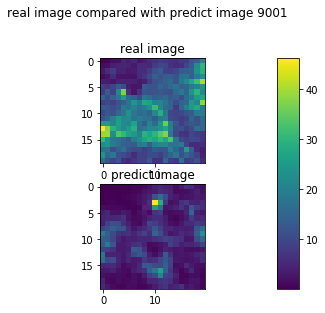

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

# print(val_image)

# plot original label image
plt.subplot(211)
plt.title('real image')
plt.imshow(image)

# plot predict image
plt.subplot(212)
plt.title('predict image')
plt.imshow(val_image)

# adjust plot location
plt.subplots_adjust(bottom=0, right=0.9, top=0.8)
cax = plt.axes([0.8, 0.0, 0.05, 0.8])
plt.colorbar(cax=cax)
plt.suptitle('real image compared with predict image {}'.format(seqs), fontsize=12)
plt.show()



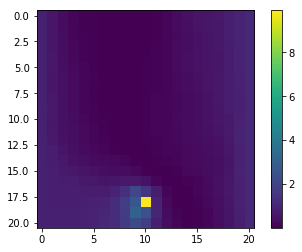

In [55]:
with open('/home/cuda/benchuang/TONG_random_forest/F0000001/Stress05.JSON_lag0','r') as f:
    data = json.loads(f.read())
    data = np.array(data)
    
# data


plt.imshow(data.astype(float))
plt.colorbar()
plt.show()
